In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Gradient Boosting

## Read Data

In [ ]:
#data from here https://www.kaggle.com/c/boston-housing/overview
df = pd.read_csv('https://raw.githubusercontent.com/shestakoff/hse_se_ml/master/2020/s11-boosting/data/boston_train.csv').drop(columns = 'ID')

 Prediction of house price in Boston.
 
 Why it's important? Because it can help people determine a fair price at home.

In [ ]:
X = df.drop(columns = 'medv').values
y = df['medv'].values

In [ ]:
X.shape

(333, 13)

## Before doing

definition of huber_loss: https://en.wikipedia.org/wiki/Huber_loss

Implement function which calculate $z_i$ from gradient boosting alogirithm (minus gradient of loss function). Implement for all possible loss function (mse, hl, logloss)

In hl use $\delta = 1$, assume that $MSE = \frac{1}{2}(r - y)^2$ and log_loss(sigmoid(r)) use $0$ and $1$ like class label

In [ ]:
def calc_objective(r, target, loss = 'mse'):
    """
    Parameters
        ----------
        r : np.array
            value of f(x)
        target : np.array
            target
        loss : str
            loss function. Possible values : mse, hl(https://en.wikipedia.org/wiki/Huber_loss, logloss(sigmoid(r))
    """
    if loss == 'mse':
      return -(r - target)

    elif loss == 'logloss':
      sigmoid = lambda x:1/(1+np.exp(-x))
      confidence = sigmoid(r) - target
      return - confidence

    elif loss == 'hl':
      delta = 1
      d = np.abs(target - r)
      return np.where(d <= delta,
                 -(r - target),
                 -delta * np.sign(r - target))

    else:
      raise ValueError
      print('{} not implemented'.format(loss))

In [ ]:
#test your code

r = np.array([1, 2, 3, 4, 5])
target = np.array([10, 9, 8, 7, 6])
assert(np.allclose(calc_objective(r, target, 'mse'), np.array([9, 7, 5, 3, 1]), 0.00001))

r = np.array([2, 4, 7, 9, 13])
target = np.array([2.5, 6, 10, 6, 12.75])
assert(np.allclose(calc_objective(r, target, 'hl'), np.array([0.5, 1, 1, -1, -0.25]), 0.00001))

r = np.array([0, np.log(2), -np.log(9), np.log(4), np.log(19)])
target = np.array([0, 1, 0, 1, 1])
assert(np.allclose(calc_objective(r, target, 'logloss'), np.array([-0.5, 1. / 3, -0.1, 0.2, 0.05]), 0.00001))

Implement function which makes one step of gradient boossting (fit new estimator)

In [ ]:
def step(X, y, r, base_estimator, loss = 'mse'):
    """
    Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
        y : numpy.array, shape = (n_objects)
            1D array with the target variables
        r : np.array, shape = (n_ojects)
            f_{m-1}(X) (X matrix of features) - prediction of previous m-1 base_estimators
        base_estimator : estimator which you must fit
            has got method fit
        loss : str
            loss function. Possible values : mse, hl, logloss
            
        Return fitted base_estimator
    """
    residuals = calc_objective(r, y, loss=loss)
    return base_estimator.fit(X,  residuals)

## Now use your knowledge and implement gradient boosting

# Task 1 (6 points)

Implement GradientBoostingRegressor as it was described in your lectures:

**Input**: training dataset $(x_{i},y_{i}),\,i=1,2,...N$; loss function $\mathcal{L}(f,y)$; learning rate $\nu$ and the number $M$ of successive additive approximations.

1. Fit initial approximation $f_{0}(x)$ (might be taken $f_{0}(x)\equiv0$)
2. For each step $m=1,2,...M$:

    1. calculate derivatives $z_{i}=-\frac{\partial\mathcal{L}(r,y_{i})}{\partial r}|_{r=f^{m-1}(x_{i})}$
    2. fit $h_{m}$ to $\{(x_{i},z_{i})\}_{i=1}^{N}$, for example by solving
$$
\sum_{n=1}^{N}(h_{m}(x_{n})-z_{n})^{2}\to\min_{h_{m}}
$$
    4. set $f_{m}(x)=f_{m-1}(x)+\nu h_{m}(x)$


**Output**: approximation function $f_{M}(x)=f_{0}(x)+\sum_{m=1}^{M}\nu h_{m}(x)$

Implement three loss functions:

    1 MSE
    2 Huber loss(https://en.wikipedia.org/wiki/Huber_loss)
    3 log_loss (in this case we solve classification task
In our case $h_m$ is DecisionTreeRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# You need to modify this class #

class GradientBoostingEstimator(object):

    def __init__(self, n_estimators=10, max_depth = 3, max_leaf_nodes = 8, n_subset_features = 5, random_state = 42,
                 loss = 'mse', learning_rate=0.1):
        """
        This is your random forest classifier.
        
        Parameters
        ----------
        n_estimators : int
            Number of estimators to train.
        max_depth : int
            max_depth of DecisionTreeRegressor
        max_leaf_nodes:
            max_leaf_nodes of DecisionTreeRegressor
        n_subset_features : int
            Number of random features to used to train a decision tree
        random_state : int
            random_state for decision tree
        loss : str
            Loss. Possible values : mse, hl, logloss
        learning_rate : float
            learning_rate (coef for next estimator on each step)
        """


        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.estimators = []
        self.base_estimator = DecisionTreeRegressor(max_depth = max_depth, max_leaf_nodes = max_leaf_nodes, max_features=n_subset_features, random_state = 42)
        self.loss = loss

    def fit(self, X, y):
        """
        Fit the classifier.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
        y : numpy.array, shape = (n_objects)
            1D array with the object labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
        """
        from sklearn.base import clone
        
        r = np.zeros(shape=X.shape[0])
        
       
        for i in range(self.n_estimators):

          base_estimator = clone(self.base_estimator)
            
          fitted_estimator = step(X, y, r, base_estimator, loss = self.loss)

          self.estimators.append(fitted_estimator)

          r_new = fitted_estimator.predict(X)

          r = r + self.learning_rate*r_new
       

          
        
        
            
    def predict(self, X):
        """
        This methods performs labels prediction for new objects.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
            
        Returns
        -------
        labels : numpy.array, shape = (n_objects)
            1D array with predicted labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
        """
        prediction = np.zeros(shape=X.shape[0])

        if self.loss=='mse' or self.loss=='hl':
          for estimator in self.estimators:
              prediction += self.learning_rate*estimator.predict(X)
          return prediction


          
        
        elif self.loss=='logloss':
          for estimator in self.estimators:
            prediction += self.learning_rate*(1/(1+np.exp(estimator.predict(X))))
          return np.where(1/(1+np.exp(prediction))>0.5, 1,0) 


    
    def predict_proba(self, X):
        """
        This methods performs probabilities prediction for new objects.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
            
        Returns
        -------
        proba : numpy.array, shape = (n_objects, n_classes)
            Array with predicted probabilities. 
        """
        prediction = np.zeros(shape=X.shape[0])

        for estimator in self.estimators:

           prediction += self.learning_rate*1/(1+np.exp(estimator.predict(X)))

        return 1/(1 + np.exp(prediction))


### Important
When you select `learning_rate` and `n_estimators`, follow the default values of the tree parameters

# Task 2 (2 points)

Split your data on train, valid sample (fix random_seed). Choose the best `learning_rate` and `n_estimators` for every loss (for logloss use data from previous HW). For regression task (mse_loss, huber_loss) use MSE on valid sample as quality measure to choose optimal params, for classification task (logloss) use ROC-AUC.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42, test_size=0.2)

In [ ]:
results = {}
best = (float('inf'), None)
for i in np.arange(50, 300, 10):
  reg = GradientBoostingEstimator(n_estimators=i, loss='mse')
  reg.fit(X_train, y_train)
  mse = mean_squared_error(y_valid, reg.predict(X_valid))
  results[i] = mse
  if mse< best[0]:
    best = (mse, i)

print(results)

{50: 0.2918149466192171, 60: 0.2918149466192171, 70: 0.2918149466192171, 80: 0.2918149466192171, 90: 0.2918149466192171, 100: 0.2918149466192171, 110: 0.2918149466192171, 120: 0.2918149466192171, 130: 0.2918149466192171, 140: 0.2918149466192171, 150: 0.2918149466192171, 160: 0.2918149466192171, 170: 0.2922103598260182, 180: 0.29240806642941874, 190: 0.2926057730328193, 200: 0.2926057730328193, 210: 0.29280347963621983, 220: 0.29280347963621983, 230: 0.2930011862396204, 240: 0.2930011862396204, 250: 0.29280347963621983, 260: 0.29280347963621983, 270: 0.29280347963621983, 280: 0.29280347963621983, 290: 0.29280347963621983}


Best number of estimators for MSE

In [ ]:
best 

(9.677064465095649, 100)

In [ ]:
results = {}
best = (float('inf'), None)
for i in np.append(np.arange(0.005, 1, 0.01), np.array([0.1,0.2,0.3])):
  reg = GradientBoostingEstimator(n_estimators=100, learning_rate=i, loss='mse')
  reg.fit(X_train, y_train)
  mse = mean_squared_error(y_valid, reg.predict(X_valid))
  results[i] = mse
  if mse< best[0]:
    best = (mse, i)

print(results)

{0.005: 235.2674286365268, 0.015: 50.51704919646147, 0.024999999999999998: 18.247595801127776, 0.034999999999999996: 16.32297898585152, 0.04499999999999999: 12.22624823620786, 0.054999999999999986: 12.348928030072184, 0.06499999999999999: 12.676438166102393, 0.075: 15.345701687424457, 0.08499999999999999: 9.910537974346726, 0.09499999999999999: 18.12562586445554, 0.10499999999999998: 15.7115812214083, 0.11499999999999999: 15.215029608324441, 0.12499999999999999: 10.104706326951556, 0.13499999999999998: 18.62837418243543, 0.145: 16.31014956911653, 0.15499999999999997: 13.375733333937863, 0.16499999999999998: 15.687075496169275, 0.175: 10.679062346668072, 0.18499999999999997: 9.991985918869338, 0.19499999999999998: 16.323750202044046, 0.20499999999999996: 16.49580743905389, 0.21499999999999997: 12.024596380901025, 0.22499999999999998: 14.173597988422257, 0.23499999999999996: 10.303366113630899, 0.24499999999999997: 10.178479248934227, 0.25499999999999995: 12.080178395286678, 0.2649999999

Best learning rate for mse

In [ ]:
best

(9.677064465095649, 0.1)

In [ ]:
results = {}
best = (float('inf'), None)
for i in np.arange(50, 300, 10):
  reg = GradientBoostingEstimator(n_estimators=i, loss='hl')
  reg.fit(X_train, y_train)
  mse = mean_squared_error(y_valid, reg.predict(X_valid))
  results[i] = mse
  if mse< best[0]:
    best = (mse, i)

print(results)

{50: 391.8242260777612, 60: 358.0650419888635, 70: 326.2968079264424, 80: 296.54505092988177, 90: 268.8169114744145, 100: 243.05273164915744, 110: 219.072430898623, 120: 197.01129517381213, 130: 176.8904801426696, 140: 158.8884448651366, 150: 142.6757029366815, 160: 128.4522282693278, 170: 115.58409429776023, 180: 104.24103037321824, 190: 94.72128879023894, 200: 86.06149452659838, 210: 79.45696019455073, 220: 72.96422820231679, 230: 66.22528106695735, 240: 60.33568203138516, 250: 55.40060214331693, 260: 50.60549825817814, 270: 46.717231619026656, 280: 43.17104382939798, 290: 39.778317232560546}


Best number of estimators huber

In [ ]:
best

(39.778317232560546, 290)

In [ ]:
results = {}
best = (float('inf'), None)
for i in np.arange(0.005, 0.2, 0.001):
  reg = GradientBoostingEstimator(n_estimators=290, learning_rate=i, loss='hl')
  reg.fit(X_train, y_train)
  mse = mean_squared_error(y_valid, reg.predict(X_valid))
  results[i] = mse
  if mse< best[0]:
    best = (mse, i)

print(results)

{0.005: 527.7759328358212, 0.006: 515.7246149253731, 0.007: 503.841497014926, 0.008: 492.12657910447757, 0.009000000000000001: 480.57986119403057, 0.01: 469.20134328358284, 0.011: 457.9910253731341, 0.012: 446.94890746268646, 0.013000000000000001: 436.07498955223946, 0.014000000000000002: 425.369271641792, 0.015: 414.83175373134327, 0.016: 404.4624413048579, 0.017: 394.26144878369223, 0.018000000000000002: 384.2277407948522, 0.019: 374.3604028678765, 0.02: 364.6589772253966, 0.021: 355.12324798180373, 0.022000000000000002: 345.75533051353773, 0.023000000000000003: 336.5591510399302, 0.024: 327.5302982366044, 0.025: 318.66699363727673, 0.026000000000000002: 309.9691416755569, 0.027: 301.4633276242015, 0.028: 293.1317560401332, 0.029: 284.9647226668434, 0.030000000000000002: 276.94419164632524, 0.031000000000000003: 269.08786869274826, 0.032: 261.406655329802, 0.033: 253.89237837114754, 0.034: 246.54269595782367, 0.034999999999999996: 239.31818172378897, 0.036: 232.2327846770494, 0.037: 

Best learning rate Huber

In [ ]:
best

(13.437981349352189, 0.189)

In [ ]:
X = pd.read_csv('https://raw.githubusercontent.com/shestakoff/hse_se_ml/master/2020/s10-ensembles/data/x_train.csv', sep=';')
y = pd.read_csv('https://raw.githubusercontent.com/shestakoff/hse_se_ml/master/2020/s10-ensembles/data/y_train.csv', sep=';', header=None, names=['target'])
X = X.values
y = y['target'].values
X_train_, X_val_, y_train_, y_val_ = train_test_split(X, y, 
                                                    test_size=0.3,    
                                                    random_state=42)

In [ ]:
results = {}
best = (float('-inf'), None)
for i in np.arange(50, 300, 10):
  clf = GradientBoostingEstimator(n_estimators=i, loss='logloss')
  clf.fit(X_train_, y_train_)
  roc_auc = roc_auc_score(y_val_, clf.predict_proba(X_val_))
  results[i] = roc_auc
  if roc_auc> best[0]:
    best = (roc_auc, i)

print(results)

{50: 0.8823157604728654, 60: 0.8827230584051291, 70: 0.8830633693089374, 80: 0.883343874865711, 90: 0.8836332840275205, 100: 0.8840584731661304, 110: 0.884343304531011, 120: 0.8843696373628864, 130: 0.8844982776564032, 140: 0.8846203662405536, 150: 0.8846291018530419, 160: 0.8845313301901927, 170: 0.884539981806407, 180: 0.8845443916107881, 190: 0.88457727615203, 200: 0.8845802580197543, 210: 0.8847537523235469, 220: 0.8848198153929892, 230: 0.8848547578429421, 240: 0.8848718930828228, 250: 0.8849834821327326, 260: 0.8850447994126982, 270: 0.8850798678570618, 280: 0.8851222439772571, 290: 0.8851761695851172}


Best number of estimators for logloss

In [ ]:
best

(0.8851761695851172, 290)

In [ ]:
results = {}
best = (float('-inf'), None)
for i in np.arange(0.005, 0.2, 0.01):
  clf = GradientBoostingEstimator(n_estimators=290, learning_rate=i, loss='logloss')
  clf.fit(X_train_, y_train_)
  roc_auc = roc_auc_score(y_val_, clf.predict_proba(X_val_))
  results[i] = roc_auc
  if roc_auc> best[0]:
    best = (roc_auc, i)

print(results)

{0.005: 0.8756004683632234, 0.015: 0.8821368064112676, 0.024999999999999998: 0.8831731104408207, 0.034999999999999996: 0.8841461652761085, 0.04499999999999999: 0.8844868541631493, 0.054999999999999986: 0.8845866837347094, 0.06499999999999999: 0.8847416568601016, 0.075: 0.8847793291889572, 0.08499999999999999: 0.8850221624168751, 0.09499999999999999: 0.8850647905258924, 0.10499999999999998: 0.8851147263107408, 0.11499999999999999: 0.8852927984114625, 0.12499999999999999: 0.8852539921329089, 0.13499999999999998: 0.8852095161058654, 0.145: 0.8853171153327637, 0.15499999999999997: 0.8855230321982916, 0.16499999999999998: 0.8854004816346346, 0.175: 0.8854119051278886, 0.18499999999999997: 0.885452895309564, 0.19499999999999998: 0.8853499998740055}


Best learning rate for logloss

In [ ]:
best

(0.8855230321982916, 0.15499999999999997)

# Task 3 (1 point)
Plot dependecy of loss value (in classification task plot roc-auc score) from `n_estimators` of your boosting. Use `learning_rate=0.1`.

In [ ]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'MSE')

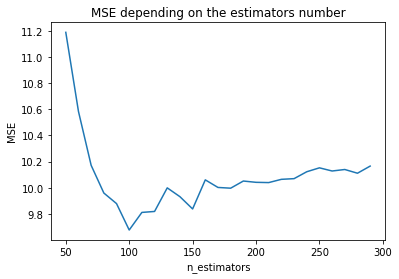

In [ ]:
errors = []
n_estimators = []
for i in np.arange(50, 300, 10):
  reg = GradientBoostingEstimator(n_estimators=i,learning_rate=0.1, loss='mse')
  reg.fit(X_train, y_train)
  mse = mean_squared_error(y_valid, reg.predict(X_valid))
  errors.append(mse)
  n_estimators.append(i)

plt.plot(n_estimators, errors)
plt.title('MSE depending on the estimators number')
plt.xlabel('n_estimators')
plt.ylabel('MSE')

Text(0, 0.5, 'hl')

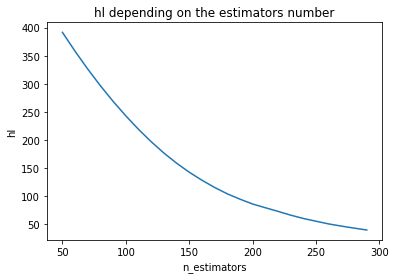

In [ ]:
errors = []
n_estimators = []
for i in np.arange(50, 300, 10):
  reg = GradientBoostingEstimator(n_estimators=i,learning_rate=0.1, loss='hl')
  reg.fit(X_train, y_train)
  mse = mean_squared_error(y_valid, reg.predict(X_valid))
  errors.append(mse)
  n_estimators.append(i)

plt.plot(n_estimators, errors)
plt.title('hl depending on the estimators number')
plt.xlabel('n_estimators')
plt.ylabel('hl')

Text(0, 0.5, 'roc_auc')

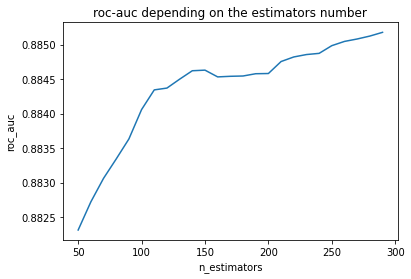

In [ ]:
errors = []
n_estimators = []
for i in np.arange(50, 300, 10):
  cls = GradientBoostingEstimator(n_estimators=i,learning_rate=0.1, loss='logloss')
  cls.fit(X_train_, y_train_)
  roc_auc = roc_auc_score(y_val_, cls.predict_proba(X_val_))
  errors.append(roc_auc)
  n_estimators.append(i)

plt.plot(n_estimators, errors)
plt.title('roc-auc depending on the estimators number')
plt.xlabel('n_estimators')
plt.ylabel('roc_auc')

# Task 4 (1 point)
Plot dependecy of loss value (in classification task plot roc-auc score) from `learning_rate` of your boosting. Use `n_estimators=100`.

Text(0, 0.5, 'MSE')

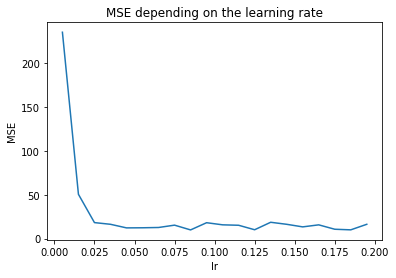

In [ ]:
errors = []
lrs = []
for i in np.arange(0.005, 0.2, 0.01):
  reg = GradientBoostingEstimator(n_estimators=100,learning_rate=i, loss='mse')
  reg.fit(X_train, y_train)
  mse = mean_squared_error(y_valid, reg.predict(X_valid))
  errors.append(mse)
  lrs.append(i)

plt.plot(lrs, errors)
plt.title('MSE depending on the learning rate')
plt.xlabel('lr')
plt.ylabel('MSE')

Text(0, 0.5, 'hl')

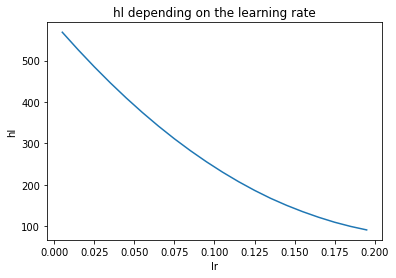

In [ ]:
errors = []
lrs = []
for i in np.arange(0.005, 0.2, 0.01):
  reg = GradientBoostingEstimator(n_estimators=100,learning_rate=i, loss='hl')
  reg.fit(X_train, y_train)
  mse = mean_squared_error(y_valid, reg.predict(X_valid))
  errors.append(mse)
  lrs.append(i)

plt.plot(lrs, errors)
plt.title('hl depending on the learning rate')
plt.xlabel('lr')
plt.ylabel('hl')

Text(0, 0.5, 'roc_auc')

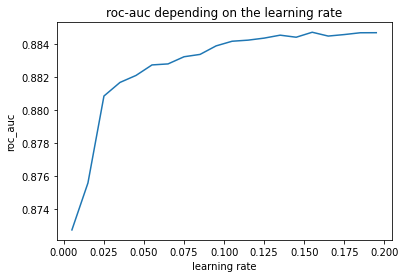

In [ ]:
errors = []
lrs = []
for i in np.arange(0.005, 0.2, 0.01):
  cls = GradientBoostingEstimator(n_estimators=100,learning_rate=i, loss='logloss')
  cls.fit(X_train_, y_train_)
  roc_auc = roc_auc_score(y_val_, cls.predict_proba(X_val_))
  errors.append(roc_auc)
  lrs.append(i)

plt.plot(lrs, errors)
plt.title('roc-auc depending on the learning rate')
plt.xlabel('learning rate')
plt.ylabel('roc_auc')